# Supplemental: Spatial Autocorrelation in Cortical Timescale
Exploring different ways of accounting for spatial autocorrelation, mainly following variogram-fitting method from brainSMASH (Burt et al., 2020, bioRxiv) and Moran Spectral Randomization (MSR) from BrainSpace (Vos de Wael et al., 2020, Communications Biology).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
from brainsmash.mapgen.base import Base
from seaborn import despine

import sys
sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
df_tau = pd.read_csv('../data/df_tau_avg.csv', index_col=0)
df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)

# take out genes because there's a lot of operating on them
df_genes = df_struct[df_struct.columns[1:]]

# parcel geodesic distance
df_parcel_geo = pd.read_csv('../data/LeftParcelGeodesicDistmat.txt', header=None, delimiter=' ')


---
# Variogram
### Computing variogram from cortical geodesic distance
The variogram, in short, measures pairwised squared difference of values (in this case, timescale) as a function of distance. At the lowest level, between every pair of locations, you can compute the squared difference, which is the cell immediately below. What results is an n x n matrix (n = number of parcels), which is also the same size as the distance matrix, of which we take the upper triangle.

In Burt et al., 2020, the variogram x-axis is chosen with equidistant bins, and every pairwise distance would fall within on of `nh` number of bins, and the variogram value (y-value) at that distance is a weighted average of all the values that fell in that bin, with the weighting being a distance-dependent kernel such that a pairwise mean-squared difference value is weighted more if the pairwise distance was closer to the bin value. This is done in the cell after. 

I don't know why these decisions are made, because it will:
1. prioritize over certain distances, namely, those that fell on the bin centers, such that distances (and values) that are at the bin edges are de-weighted for no real reason other than the fact that we arbitrarily picked some bin centers. As per L88 in Burt et al 2020, it's implied that the smoothing kernel is applied after binning, but I think it would make more sense to smooth continuously before binning, though that would be computationally expensive.

2. ignore the density of the distances because, as we will see below, the pairwise distances follow a normal-ish distribution that is densest near the half way point, which makes sense, because every point in a closed surface (like a sphere) has more points that are half-way closest to it than very close or very far from it.

((0.12539002855131479, 1.8480773277884942e-57),
 (-0.014135529195085353, 0.07279642311405778))

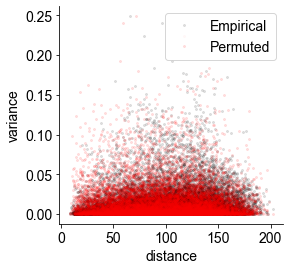

In [3]:
x = df_tau['logtau'].values

# getting pair-wise distance in vector form
x_dist = df_parcel_geo.values[np.triu_indices(len(x),k=1)]

# getting pairwise var using pdist
x_var = pdist(x[:,None])**2/2 # pdist computes and grabs upper triangle of distance matrix
# the above is identical to: 
# gen = Base(x, df_parcel_geo.values)

# make a permuted version
x_perm = np.random.permutation(x)
x_var_null = pdist(x_perm[:,None])**2/2

# plot
plt.figure(figsize=(4,4))
plt.plot(x_dist, x_var, '.k', ms=4, alpha=0.1, label='Empirical');
plt.plot(x_dist, x_var_null, '.r', ms=4, alpha=0.1, label='Permuted');
plt.xlabel('distance'); plt.ylabel('variance')
plt.legend(); despine()
pearsonr(x_dist, x_var), pearsonr(x_dist, x_var_null)

### Binning for variogram
To compute the actual variogram, we have to bin and average over some distance bins, then also smooth. My code below only does binning, and not weighting by distance from bin centers.

See: https://brainsmash.readthedocs.io/en/latest/source/brainsmash.mapgen.html#brainsmash.mapgen.Base.compute_variogram

In [4]:
def compute_variogram(x_var, x_dist, nh, pv):
    # truncate the distance distribution based on pv
    x_dist_trunc = x_dist[x_dist<=np.quantile(x_dist, pv/100)]
    x_var_trunc = x_var[x_dist<=np.quantile(x_dist, pv/100)]
    
    # evenly bin the remaining distances based on nh
    dist_bins = np.linspace(x_dist_trunc.min(), x_dist_trunc.max(), nh)
    x_dist_inds = np.digitize(x_dist_trunc, dist_bins)

    variogram = []
    for i in np.unique(x_dist_inds):
        x_curr = x_var_trunc[x_dist_inds==i]
        variogram.append([x_curr.mean(), x_curr.std()])
        
    return dist_bins, np.array(variogram)    

In [7]:
nh = 50
pv = 90

# make 1000 nulls 
# THIS TAKES A SECOND
gen = Base(x, df_parcel_geo.values, kernel='exp', nh=nh, pv=pv, resample=False)
n_rand = 1000
vg_nulls = gen(n_rand)

adjusted correlation: r = -0.466, p = 0.014


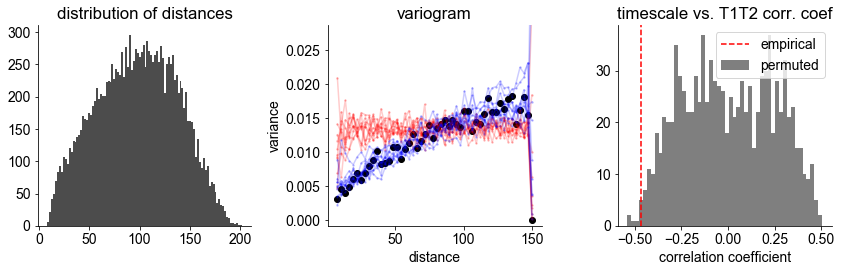

In [10]:
n_nulls = 10

# plot distribution of distances
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(x_dist, 100, color='k', alpha=0.7)
plt.title('distribution of distances')

plt.subplot(1,3,2)
# plot empirical variogram
dists, vagm = compute_variogram(x_var, x_dist, nh, pv)
plt.plot(dists, vagm[:,0], 'ok')
YL = plt.ylim()

# make a few permuted maps (that does not smooth or preserve SA, unlike in brainSMASH)
for i in range(n_nulls):    
    x_perm = np.random.permutation(x)
    x_var_null = pdist(x_perm[:,None])**2/2
    dists, vagm = compute_variogram(x_var_null, x_dist, nh, pv)
    plt.plot(dists, vagm[:,0], 'r.-', alpha=0.2, ms=3)

# make SA-preserving nulls & plot their variogram
for null in gen(n_nulls):
    x_var_null = pdist(null[:,None])**2/2
    dists, vagm = compute_variogram(x_var_null, x_dist, nh, pv)
    plt.plot(dists, vagm[:,0], 'b.-', alpha=0.2, ms=3)
    
plt.ylim([YL[0], YL[1]*1.5]);
plt.title('variogram'); plt.xlabel('distance'); plt.ylabel('variance')

# and run against t1t2 map
rho_null = np.array([spearmanr(n_, df_struct['T1T2'].values)[0] for n_ in vg_nulls])
rho = spearmanr(x, df_struct['T1T2'].values)[0]

plt.subplot(1,3,3)
plt.hist(rho_null, 50, color='k', alpha=0.5, label='permuted');
plt.axvline(rho, color='r', ls='--', label='empirical')
print('adjusted correlation: r = %.3f, p = %.3f'%(rho, (abs(rho)<abs(rho_null)).sum()/n_rand))
plt.legend()
plt.title('timescale vs. T1T2 corr. coef')
plt.xlabel('correlation coefficient')
plt.tight_layout(); despine()

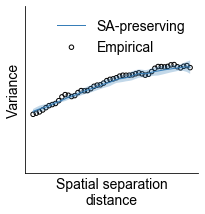

In [11]:
# compare with variogram computed from brainSMASH, not sure why the y-axis is squished
from brainsmash.mapgen.eval import base_fit
base_fit(x, df_parcel_geo.values, 10, kernel='exp', nh=nh, pv=pv, resample=False)

### Some notes on variaogram:
In this case, the null hypothesis for permuted maps is that they should preserve the variogram. There are a few parameter choices for computing variograms, especially in brainSMASH, that I don't have a good grasp on. 

For example, `pv`, which is what proportion of the pairwise distance distribution to use for fitting the variogram (how much of the x-axis to include from the left when fitting the linear model). As we see in the empirical variogram, it's non-linear past about the 70th percentile (though it's unclear how the SA-preserving nulls were still able to fit the empirical one given that it's fit with linear regression EDIT: the permuted-map variogram themselves can be highly nonlinear, only the scaling transform is linear). The package uses `pv=25` as default, citing that most SA effects are local, though unclear why this choice is made and to what extent that is true?

Other parameter choices, such as kernel shape (exponential or gaussian), kernel width, % of neighbors over which to compute the variance, all affect the resulting maps.

---

# Moran Spectral Randomization (MSR)
Following the math in Vos de Wael et al., 2020 and Wagner & Dray 2015, MSR does eigendecomposition on the neighborness matrix (inverse geodesic distance between parcels in this case). The spatial autocorrelation is preserved (in the singleton method) by finding random vectors with element-wise altered signs but preserved magnitudes that project back onto the eigenvectors.



adjusted correlation: r = -0.466, p = 0.000


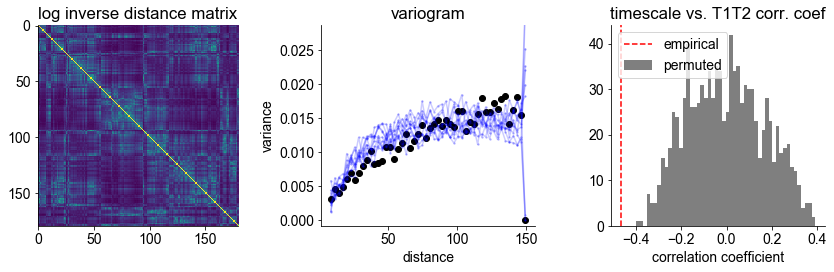

In [12]:
from brainspace.null_models import MoranRandomization

# get inverse geodesic distance map
w_igd = 1/(df_parcel_geo.values + np.eye(len(x)))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.log10(w_igd))
plt.title('log inverse distance matrix')

# do Moran decomposition on distance matrix
msr = MoranRandomization(n_rep=n_nulls, procedure='singleton', tol=1e-6, random_state=42)
msr.fit(w_igd)

# make SA-preserving nulls & plot their variogram on top of the empirical again
plt.subplot(1,3,2)
# plot empirical variogram
dists, vagm = compute_variogram(x_var, x_dist, nh, pv)
plt.plot(dists, vagm[:,0], 'ok')
YL = plt.ylim()

for null in msr.randomize(x):
    x_var_null = pdist(null[:,None])**2/2
    dists, vagm = compute_variogram(x_var_null, x_dist, nh, pv)
    plt.plot(dists, vagm[:,0], 'b.-', alpha=0.2, ms=3)
    
plt.ylim([YL[0], YL[1]*1.5]);
plt.title('variogram'); plt.xlabel('distance'); plt.ylabel('variance')

# make 1000 nulls and run against t1t2 map
n_rand = 1000
ts_msr = MoranRandomization(n_rep=n_rand, procedure='singleton', tol=1e-6, random_state=42)
ts_msr.fit(w_igd)
msr_nulls = ts_msr.randomize(x)
rho_null = np.array([spearmanr(n_, df_struct['T1T2'].values)[0] for n_ in msr_nulls])
rho = spearmanr(x, df_struct['T1T2'].values)[0]

plt.subplot(1,3,3)
plt.hist(rho_null, 50, color='k', alpha=0.5, label='permuted');
plt.axvline(rho, color='r', ls='--', label='empirical')
print('adjusted correlation: r = %.3f, p = %.3f'%(rho, (abs(rho)<abs(rho_null)).sum()/n_rand))
plt.legend()
plt.title('timescale vs. T1T2 corr. coef')
plt.xlabel('correlation coefficient')
plt.tight_layout(); despine()

### Plot top few Moran eigenvector maps

colormap sequential: [-1.63e-01, -2.41e-02, 1.15e-01] (opaque)
colormap sequential: [-1.21e-01, 1.51e-02, 1.51e-01] (opaque)
colormap sequential: [-1.55e-01, -5.46e-04, 1.53e-01] (opaque)
colormap sequential: [-1.88e-01, -3.16e-02, 1.25e-01] (opaque)
colormap sequential: [-1.47e-01, -2.95e-03, 1.41e-01] (opaque)


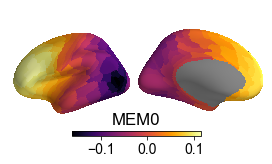

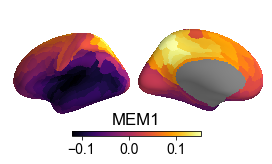

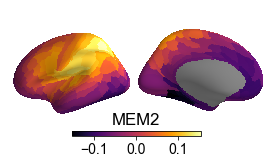

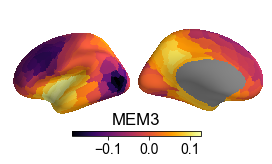

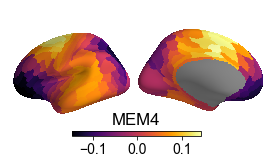

In [13]:
for i in range(5):
    plt.figure(figsize=(4,4))
    echo_utils.plot_MMP(msr.mem_[:,i], bp=0, title='MEM%i'%i)

### Empirical & null correlations for variogram-fitting vs. MSR
One of the issues raised in Burt et al. 2020 is that MSR creates null maps that can be highly correlated with the empirical map itself, so we examine whether this is the case here.

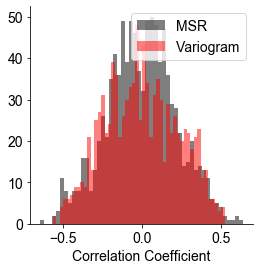

In [14]:
rho_null_empmsr = np.array([spearmanr(n_, x)[0] for n_ in msr_nulls])
rho_null_empvg = np.array([spearmanr(n_, x)[0] for n_ in vg_nulls])
plt.figure(figsize=(4,4))
plt.hist(rho_null_empmsr,50, color='k', alpha=0.5, label='MSR')
plt.hist(rho_null_empvg,50, color='r', alpha=0.5, label='Variogram')
plt.xlabel('Correlation Coefficient')
plt.legend();despine()

### Comparison notes
As shown above, the two methods are fairly similar in the variograms they produce and the correlation between the null maps they produce and the empirical map, though I think variogram-fitting highly depends on where one truncates the distance distributions. Here, we truncated at 90%, which aims to reproduce the spatial autocorrelation at almost all scales. This will change if `pv` is changed to a lower value, though I'm not sure what the rational would be to do that. MSR does eigendecomposition on the similarity (inverse-distance) matrix, which does not explicitly account for different scale.

---
# Plot some maps

### Empirical timescale map

colormap sequential: [1.00e+00, 1.35e+00, 1.70e+00] (opaque)


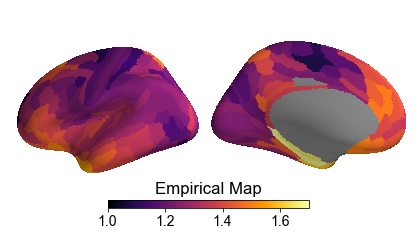

In [15]:
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(x, bp=0, minmax=[1,np.log10(50)], title='Empirical Map')

### variogram-fitting null maps

colormap sequential: [1.39e+01, 1.42e+01, 1.45e+01] (opaque)
colormap sequential: [5.32e+00, 5.63e+00, 5.93e+00] (opaque)
colormap sequential: [3.47e+00, 3.80e+00, 4.13e+00] (opaque)


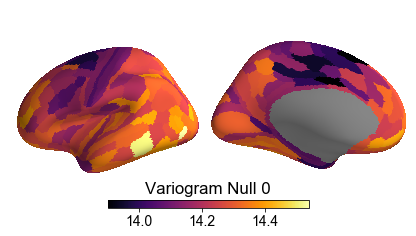

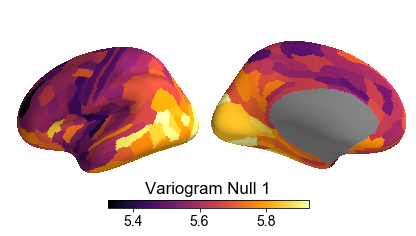

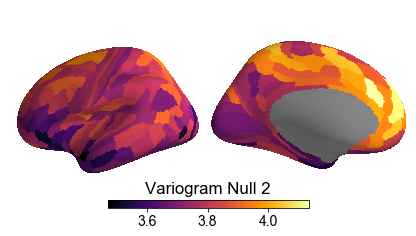

In [16]:
# variogram maps
for i in range(3):
    plt.figure(figsize=(6,6))
    echo_utils.plot_MMP(vg_nulls[i,:], bp=0, title='Variogram Null %i'%i)


### MSR null maps

colormap sequential: [9.94e-01, 1.30e+00, 1.61e+00] (opaque)
colormap sequential: [9.98e-01, 1.36e+00, 1.72e+00] (opaque)
colormap sequential: [1.03e+00, 1.33e+00, 1.63e+00] (opaque)


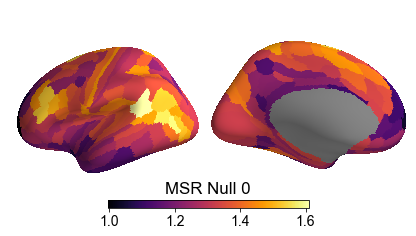

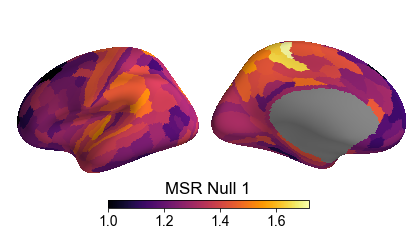

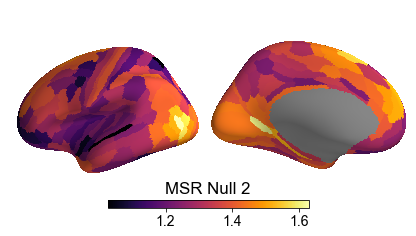

In [17]:
# MSR maps
for i in range(3):
    plt.figure(figsize=(6,6))
    echo_utils.plot_MMP(msr_nulls[i,:], bp=0, title='MSR Null %i'%i)
